Accuracy: 0.80


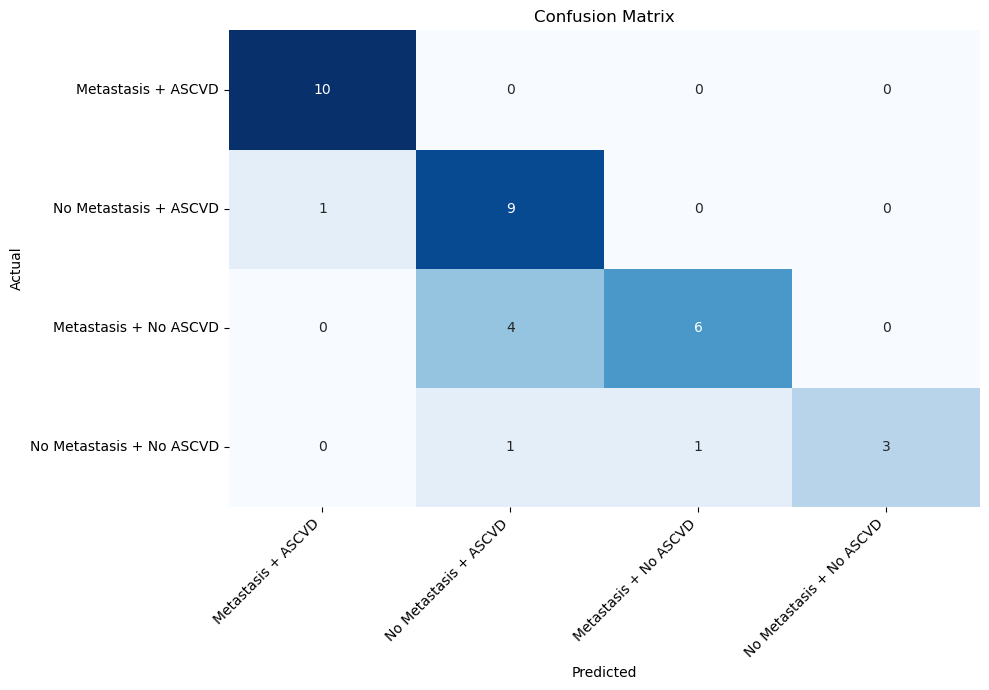

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
import pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV

warnings.filterwarnings('ignore')

###############################################################################################
## Load the xls data
# The data is available in the project file as "MM-Data_BUP_35Samples.xlsx"
###############################################################################################
xls = pd.ExcelFile(r"C:\Users\morte\Downloads\MM-Data_BUP_35Samples.xlsx")
df = pd.read_excel(xls, 'Sheet1')

###############################################################################################
## Transpose and set the column names
###############################################################################################
df               = df.T
df.columns       = df.iloc[0]
df               = df[1:]
df['Subject']    = df.index.str.split('_').str[0]
df['Replicate']  = df.index.str.split('_').str[1]


###############################################################################################
## Construct the target variable
###############################################################################################
df['Metastasis'] = np.nan
df['ASCVD']      = np.nan
df['Target']     = np.nan

### Find where contain the substring S1, S2 ..., S10 and make the target variable: "Metastasis + ASCVD"
subjects = 'S1|S2|S3|S4|S5|S6|S7|S8|S9|S10'
df.loc[df.index.str.contains(subjects), 'Metastasis'] = 1
df.loc[df.index.str.contains(subjects), 'ASCVD']      = 1
df.loc[df.index.str.contains(subjects), 'Target']     = 1 #'Metastasis + ASCVD'

### Find where contain the substring S11, S12 ..., S20 and make the target variable: "No Metastasis + ASCVD"
subjects = 'S11|S12|S13|S14|S15|S16|S17|S18|S19|S20'
df.loc[df.index.str.contains(subjects), 'Metastasis'] = 0
df.loc[df.index.str.contains(subjects), 'ASCVD']      = 1
df.loc[df.index.str.contains(subjects), 'Target']     = 2 #'No Metastasis + ASCVD'

### Find where contain the substring S21, S22 ..., S30 and make the target variable: "Metastasis + No ASCVD"
subjects = 'S21|S22|S23|S24|S25|S26|S27|S28|S29|S30'
df.loc[df.index.str.contains(subjects), 'Metastasis'] = 1
df.loc[df.index.str.contains(subjects), 'ASCVD']      = 0
df.loc[df.index.str.contains(subjects), 'Target']     = 3 #'Metastasis + No ASCVD'

### Find where contain the substring S31, S32 ..., S35 and make the target variable: "No Metastasis + No ASCVD"
subjects = 'S31|S32|S33|S34|S35'
df.loc[df.index.str.contains(subjects), 'Metastasis'] = 0
df.loc[df.index.str.contains(subjects), 'ASCVD']      = 0
df.loc[df.index.str.contains(subjects), 'Target']     = 4 # 'No Metastasis + No ASCVD'

### Convert the subject to the integer
df['Subject'] = df['Subject'].str.extract('(\d+)').astype(int)

### Force Convert all columns to numeric expect the 'Target' column
df = df.apply(pd.to_numeric, errors='coerce')

###############################################################################################
## Preprocessing the data
###############################################################################################

# Group by the subject and calculate the mean of the replicates
df = df.groupby('Subject').mean()
df.to_excel(r"C:\Users\morte\Downloads\MM-Data_BUP_35Samples.xlsx")


###############################################################################################
## Train an Elastic Net model
###############################################################################################
# Drop unnecessary columns: 'Replicate', 'Metastasis', 'ASCVD'
df = df.drop(columns=['Replicate', 'Metastasis', 'ASCVD'])
X = df.drop(columns=['Target'])
y = df['Target']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train the ElasticNet model with cross-validation
elastic_net_model = LogisticRegressionCV(
    cv = 5, 
    penalty='elasticnet', 
    solver='saga',            # SAGA solver supports elastic net
    l1_ratios=[1],            # Elastic net mixing parameter
    Cs=[0.15],                 # Regularization strengths this is 1/lambda
    random_state=42,
    multi_class='multinomial'  # Handles multiclass problems
)
elastic_net_model.fit(X_scaled, y)

# Get the coefficients (one per class if multi-class)
coefficients = elastic_net_model.coef_

# Get column names from the original dataframe
feature_names = X.columns

# Create a DataFrame to pair features with their coefficients for each class
coef_df = pd.DataFrame(coefficients.T, index=feature_names, columns=[f'Class_{cls}' for cls in elastic_net_model.classes_])

# Set up the class labels mapping
class_labels = {
    1: 'Metastasis + ASCVD',
    2: 'No Metastasis + ASCVD',
    3: 'Metastasis + No ASCVD',
    4: 'No Metastasis + No ASCVD'
}

#save the coefficients to a csv file, with the class labels replaced
coef_df.columns = [class_labels[cls] for cls in elastic_net_model.classes_]
coef_df.to_csv('LASSO-coefficients.csv')

# Generate a confusion matrix
y_pred = elastic_net_model.predict(X_scaled)
cm     = confusion_matrix(y, y_pred)
cm_df  = pd.DataFrame(cm, index=class_labels.values(), columns=class_labels.values())

# Create a heatmap with proper figure size and label rotation
plt.figure(figsize=(10, 7))  # Adjust the figure size as needed
sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues", cbar=False)

# Set the title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Rotate the x-axis tick labels to prevent cutoff
plt.xticks(rotation=45, ha="right")

# Adjust layout to prevent label cutoff
plt.tight_layout()

#save the plot to a file
plt.savefig('confusion_matrix.png')

# Calculate the accuracy
accuracy = accuracy_score(y, y_pred)
print(f'Accuracy: {accuracy:.2f}')